In [1]:
!pip install fredpy

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import logit
import fredpy as fp
import datetime as dt
from dateutil.relativedelta import relativedelta
import yfinance as yf

Logit model. Independent variable is recession signal from St Louis Fed.
Regressors and transformation used:

Composite indicators:
LEI index: 6 month change
OECD amplitude adjusted: no transformation
Chicago Fed National Actcivity: no transformation

Monetary:
monetary: 10-3 term spread: no transformation


MARKET INDICATORS
SP500: 12m change in SP500
commodities: oil price shocks: real inflation-adjusted oil price 12m-change
credit spreads: AAA yield - Treasury yield



CONSUMER & LABOR INDICATORS

labor: 6-month change in 6m smoothed parttime work for economic reasons employed

HOUSING INDICATORS
permits: New Privately-Owned Housing Units Authorized in Permit-Issuing Places: 6-month change n 6m smoothed 

need to add and test on shorter time frames:
Temporary help all employees

In [3]:
#download Lei index from csv

lei=pd.read_csv('Leading Economic Index.csv',index_col=0,header=0,skiprows=26,parse_dates=True)

In [4]:
#download all time series from Fred, but spx from yahoo finance

fp.api_key = '080258476cc5891675617ed6e12ea43d'

#recessions
recessions = fp.series('USREC').as_frequency(freq='M').data

#composites
oecd=fp.series('USALOLITOAASTSAM').as_frequency(freq='M').data
nfci=fp.series('NFCI').as_frequency(freq='M').data

#Monetary

treasury=fp.series('DGS10').as_frequency(freq='M').data
tbill=fp.series('TB3MS').as_frequency(freq='M').data


#market related
sp500_prices=yf.download('^GSPC',start='1950-01-01')['Adj Close']
sp500_monthly=(sp500_prices.pct_change()+1).resample('M').prod()

inflation_index=fp.series('CPIAUCSL').as_frequency(freq='M').data
oil=fp.series('WTISPLC').as_frequency(freq='M').data
corp_aaa= fp.series('WAAA').as_frequency(freq='M').data


#consumer & labor
consumer=fp.series('UMCSENT').as_frequency('M').data
consumer.fillna(method='ffill',inplace=True)


parttime=fp.series('LNS12032198').as_frequency('M').data
temphelp=fp.series('TEMPHELPS').as_frequency('M').data

#housing
perm=fp.series('PERMIT').as_frequency(freq='M').data

[*********************100%***********************]  1 of 1 completed


In [5]:
#TRANSFORM TIME SERIES

#transform lei
lei.index=pd.to_datetime(lei.index,format='%b-%y')
today=dt.date.today()  
date_list=[date - relativedelta(years=100) if date > today else date for date in lei.index]
lei=lei.assign(dates=date_list)
lei.set_index('dates',inplace=True)
lei=lei.rename(columns={'767':'lei'})
lei_6m= lei.lei/lei.lei.shift(6)-1
lei_6m.index.name='date'


#create 12m spx returns



#create term spread
term_spread=(treasury-tbill)/100

#create 12m change in real oil price
real_oil=oil/inflation_index
real_oil_12m=real_oil/real_oil.shift(12)

#create corporate spread
corp_spread=corp_aaa-treasury



#create parttime indicator
parttime_ma=parttime.rolling(6).apply(np.mean)
parttime_6m=parttime_ma/parttime_ma.shift(6)-1

#create temphelp indicator
temphelp_6m=temphelp/temphelp.shift(6)-1





#create permits indicator
permits_ma=perm.rolling(6).apply(np.mean)
permits_6m=permits_ma/permits_ma.shift(6)-1


In [16]:
recessions

date
1854-12-01    1.0
1855-01-01    0.0
1855-02-01    0.0
1855-03-01    0.0
1855-04-01    0.0
             ... 
2022-10-01    0.0
2022-11-01    0.0
2022-12-01    0.0
2023-01-01    0.0
2023-02-01    0.0
Freq: MS, Name: value, Length: 2019, dtype: float64

In [6]:
#import spx and calc returns
spx=yf.download('^GSPC',start='1940-01-31')['Adj Close'].pct_change()+1
spx_monthly=spx.resample('M').apply(np.prod)
spx_1m=spx_monthly-1
spx_1m.index=spx_1m.index.tz_localize(None)
sp500_monthly=spx_1m.resample('M').last()
sp500_12m=(sp500_monthly+1).rolling(12).apply(np.prod)-1

[*********************100%***********************]  1 of 1 completed


In [7]:
data=pd.concat([recessions,lei_6m,oecd,nfci,term_spread,sp500_12m,real_oil_12m,corp_spread,consumer,parttime_6m,permits_6m],axis=1)
data.columns=['recessions','composite_lei','composite_oecd','composite_chicago','term_spread','sp500_12m','real_oil_12m','corp_spread','consumer','parttime_6m','permits_6m'
             ]
data['sp500_12m']=data['sp500_12m'].shift(1)
data.dropna(axis=0,inplace=True)

#create a shifted column with a 6 month lead as we want to forecast 6 months ahead
data.insert(1,'recession_shift',data.recessions.shift(-6))
train_data=data.dropna(axis=0)
train_data

,recessions,recession_shift,composite_lei,composite_oecd,composite_chicago,term_spread,sp500_12m,real_oil_12m,corp_spread,consumer,parttime_6m,permits_6m
1971-01-01,0.0,0.0,0.018223,99.198045,0.656790,0.017985,0.000978,1.009419,1.141500,72.4,0.141253,0.248120
1971-02-01,0.0,0.0,0.027273,99.637980,0.878675,0.024122,0.127735,1.014746,0.970278,78.1,0.129790,0.228638
1971-03-01,0.0,0.0,0.034091,99.966418,1.024163,0.023235,0.081006,1.017522,1.506522,78.1,0.164237,0.225118
1971-04-01,0.0,0.0,0.041002,100.179860,1.228608,0.019738,0.119157,1.020285,1.412190,78.1,0.142732,0.196937
1971-05-01,0.0,0.0,0.050114,100.289023,1.409610,0.022525,0.275147,1.017859,1.142500,80.2,0.125288,0.227614
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-01,0.0,0.0,0.017036,100.533844,-0.492927,0.016042,0.215740,1.437794,1.313289,62.8,-0.242657,0.030920
2022-03-01,0.0,0.0,0.014456,100.303704,-0.401207,0.016878,0.147669,1.604139,1.294674,59.4,-0.199629,0.072940
2022-04-01,0.0,0.0,0.005080,100.029682,-0.380232,0.019875,0.140331,1.523694,0.966500,65.2,-0.182939,0.092449
2022-05-01,0.0,0.0,-0.007576,99.722736,-0.304428,0.019181,-0.011777,1.549265,1.244405,58.4,-0.131860,0.084995


In [8]:
#run/train the model

model=logit('recession_shift ~ composite_lei + composite_oecd + composite_chicago + term_spread +   parttime_6m',data=train_data).fit()


Optimization terminated successfully.
         Current function value: 0.186848
         Iterations 9


In [9]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        recession_shift   No. Observations:                  618
Model:                          Logit   Df Residuals:                      612
Method:                           MLE   Df Model:                            5
Date:                Fri, 10 Mar 2023   Pseudo R-squ.:                  0.4901
Time:                        20:09:39   Log-Likelihood:                -115.47
converged:                       True   LL-Null:                       -226.44
Covariance Type:            nonrobust   LLR p-value:                 5.715e-46
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -55.0398     14.915     -3.690      0.000     -84.273     -25.807
composite_lei       -64.6915      9.221     -7.016      0.000     -82.763     -46.620
composite_oecd        0.5303      0.148      3.582      0.000       0.240       0.821
composite_chicago     0.6427      0.176      3.657      0.000       0.298       0.987
term_spread         -46.2366     16.207     -2.853      0.004     -78.003     -14.471
parttime_6m          -5.5128      2.310     -2.386      0.017     -10.041      -0.984
=====================================================================================
"""

In [10]:
#make predictions

regressor=pd.DataFrame({'composite_lei':data.composite_lei,
                        'composite_oecd':data.composite_oecd,
                        'composite_chicago':data.composite_chicago,
                        'term_spread':data.term_spread,
                        
                        'parttime_6m':data.parttime_6m
                        
                       
                       })
predictions=model.predict(regressor)
prediction_data=regressor.assign(recession=predictions)
prediction_data

,composite_lei,composite_oecd,composite_chicago,term_spread,parttime_6m,recession
1971-01-01,0.018223,99.198045,0.656790,0.017985,0.141253,0.008176
1971-02-01,0.027273,99.637980,0.878675,0.024122,0.129790,0.005334
1971-03-01,0.034091,99.966418,1.024163,0.023235,0.164237,0.003870
1971-04-01,0.041002,100.179860,1.228608,0.019738,0.142732,0.004181
1971-05-01,0.050114,100.289023,1.409610,0.022525,0.125288,0.002676
...,...,...,...,...,...,...
2022-08-01,-0.025126,98.974095,-0.263780,0.002678,-0.028680,0.257335
2022-09-01,-0.029338,98.818187,-0.167826,0.003890,-0.033390,0.301857
2022-10-01,-0.033698,98.686866,-0.113587,0.002635,-0.016659,0.348566
2022-11-01,-0.037320,98.576259,-0.206260,-0.002590,-0.047176,0.475152


In [11]:
confusion_matrix=model.pred_table()
TN=confusion_matrix[0,0]
FP=confusion_matrix[0,1]
FN=confusion_matrix[1,0]
TP=confusion_matrix[1,1]
confusion_matrix

array([[530.,  14.],
       [ 28.,  46.]])

In [12]:
accuracy=(TN+TP)/(TN+FN+FP+TP)
print(f'accuracy={np.round(accuracy*100)}')


#sensitivity: proportion of True positives
sensitivity=TP/(TP+FN)
print(f'sensitivity:{np.round(sensitivity*100)}')

accuracy=93.0
sensitivity:62.0


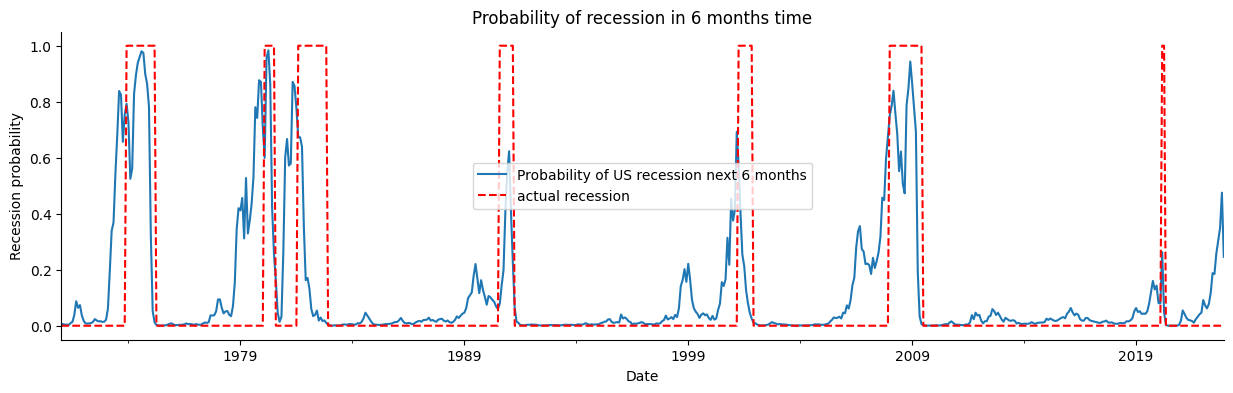

In [15]:
fix,ax=plt.subplots(figsize=(15,4))
prediction_data.recession.plot(label='Probability of US recession next 6 months')
data.recessions.plot(label='actual recession',color='red',linestyle='--')
plt.title('Probability of recession in 6 months time')
plt.xlabel('Date')
plt.ylabel('Recession probability')
plt.legend()
sns.despine()

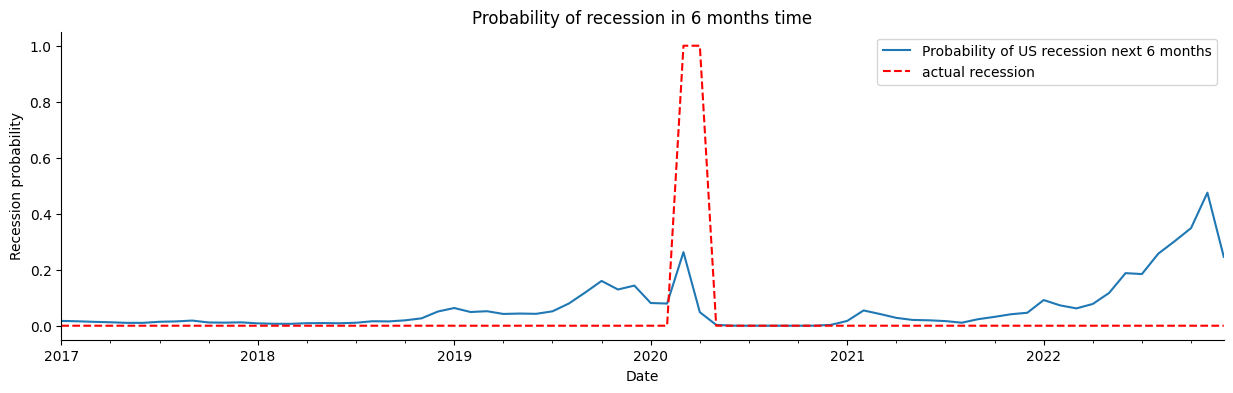

In [14]:
fix,ax=plt.subplots(figsize=(15,4))
prediction_data.recession['2017':].plot(label='Probability of US recession next 6 months')
data.recessions['2017':].plot(label='actual recession',color='red',linestyle='--')
plt.title('Probability of recession in 6 months time')
plt.xlabel('Date')
plt.ylabel('Recession probability')
plt.legend()
sns.despine()